<a href="https://colab.research.google.com/github/DiamondElectronicsGroup/Semi-Device-Modelling/blob/master/Semi_Device_Modelling_Ver1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# The aim for this project is to be able to simply model the characteristics of a semiconductor device given a number
# of properties of the device

In [0]:
import numpy as np
import pandas as pd
from scipy import constants as spcon
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]

from IPython.display import display, Math, Latex


In [0]:
#Define the scientific constants necessary for the modelling
q = spcon.elementary_charge
perm0 = spcon.epsilon_0

kB = spcon.k


#Define the material properties relevant to this specific system
permS = 11.68
semiWF = 4.47
metalWF = 4.88
dopeConc = (1 * 10 ** 20) #in units of cm^-3
hMob = 450

#Define the device parameters, such as gate length, gate width and channel depth
lGate = 20 * 10 ** (-4)        #in units of um
wGate = 200 * 10 ** (-4)        #in units of um
dChan = 100 * 10 ** (-7)        #in units of nm

#Calculate the built in voltage for the device
print('Calculate the built in voltage for the device')
vBI = (metalWF - semiWF)

display(Math(r'V_{built \ in} = \sigma_{WFmetal} - \sigma_{WFsemi} '))

#Calculate the pinch-off voltage
vP = q*((dopeConc * dChan**2) / (2 * (permS * perm0)))
print('pinch-off voltage')
display(Math(r'vP = q*((dopeConc * dChan^2) / (2 * (\epsilon_{Semi} * \epsilon_0)))'))

#Define the system voltages
vG = np.arange(0.0, 1., 0.25)
vS = 0
vD = np.arange(-2, 8, 0.005)

#Define the input array for the current calculation
inputs = np.array([q, permS, perm0, hMob, wGate, dopeConc, dChan, lGate, vBI, vP])

Calculate the built in voltage for the device


<IPython.core.display.Math object>

pinch-off voltage


<IPython.core.display.Math object>

In [0]:
#Calculate the depth of the depletion region in the MESFET (ie the region in which current is restricted)
#Only consider the built-in voltage
def BIDepletionDepth(inputs):
    
    q, permS, perm0, hMob, wGate, dopeConc, dChan, lGate, vBI, vP = inputs
    
    depth = np.sqrt(((2*permS*perm0)/(q*dopeConc))*(vBI))
    return depth

In [0]:
#Calculate the depth of the depletion region in the MESFET (ie the region in which current is restricted)
#Consider the built-in voltage and the gate voltage
def BIGDepletionDepth(inputs, vG):
    
    q, permS, perm0, hMob, wGate, dopeConc, dChan, lGate, vBI, vP = inputs
    
    depth = np.sqrt(((2*permS*perm0)/(q*dopeConc))*(vBI + vG))
    
    return depth

In [0]:
#Calculate the depth of the depletion region in the MESFET (ie the region in which current is restricted)
#Consider the built-in voltage, the gate voltage and the drain voltage
def TotDepletionDepth(inputs, vG, vD):
    
    q, permS, perm0, hMob, wGate, dopeConc, dChan, lGate, vBI, vP = inputs
    
    depth = np.zeros((len(vG), len(vD)))
    for i in range(len(vG)):
        depth[i] = np.sqrt(((2*permS*perm0)/(q*dopeConc))*(vBI + vG[i] + vD))
    
    return depth

In [0]:
#Calculate the drain current based on the operating mode of the MESFET (ie taking into account vG and vD)
def DrainCurrent(inputs, vG, vD):
    
    q, permS, perm0, hMob, wGate, dopeConc, dChan, lGate, vBI, vP, = inputs
    coeff = 2 * q * hMob * wGate * dopeConc * dChan / lGate
    depthBIG = BIGDepletionDepth(inputs, vG)
    depthTot = TotDepletionDepth(inputs, vG, vD)
    
    #Define the array that will hold the values for the current
    iD = np.zeros((len(vG),len(vD)))
    iDSat = np.zeros((len(vG)))

    
    for i in range(len(vG)):
        #Calculate the saturation current, which is reached when vD = VDSat
        iDSat[i] = coeff * (vG[i] - vBI + vP - (2/3)*(vP - ((vG[i] - vBI)/np.sqrt(vP))**(1.5)))          
        for j in range(len(vD)):
            depDepth = max(depthBIG[i], depthTot[i][j])
        
            if depDepth >= dChan:
                iD[i][j] = 0
        
            elif vD[j] >= (vG[i] - vBI + vP):
                iD[i][j] = iDSat[i]
        
            elif vD[j] < (vG[i] - vBI + vP) and vD[j] > 0:
                GDTerm = ((vG[i] - vBI + vD[j])/np.sqrt(vP))
                GTerm = ((vG[i] - vBI)/np.sqrt(vP))
                iD[i][j] = coeff * (vD[j] - (2/3)*(GDTerm**(1.5) - GTerm**(1.5)))
            
            else:
                iD[i][j] = 0

    return iD, iDSat

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


The depth of the cunducting channel is  9.999999999999999e-06 
The depth of the depletion region due to the built-in voltage is  2.3006339048302196e-06 
The depth of the depletion region due to the built-in voltage and the gate voltage is  [2.30063390e-06 2.91895604e-06 3.42749069e-06 3.86976491e-06]


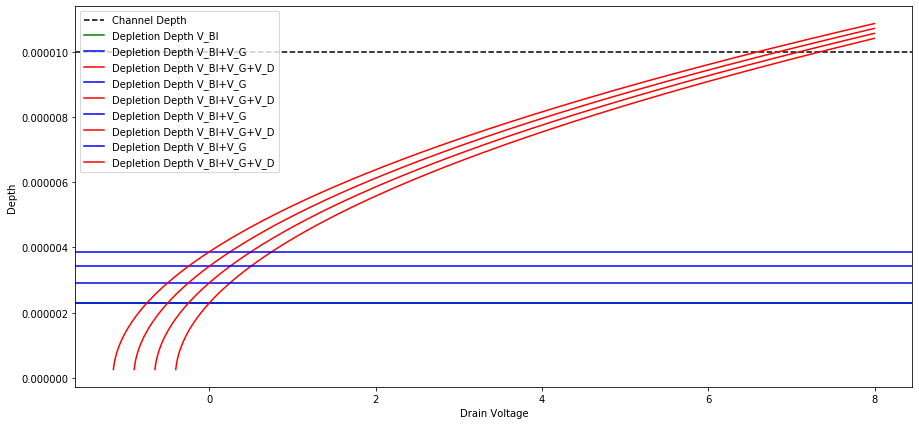

In [0]:
#Find the built in depletion depth and the depletion depth with the current vG and vD
depthBI = BIDepletionDepth(inputs)
depthBIG = BIGDepletionDepth(inputs, vG)
depthTot = TotDepletionDepth(inputs, vG, vD)

print('The depth of the cunducting channel is ', dChan, '\nThe depth of the depletion region due to the built-in voltage is ', depthBI, '\nThe depth of the depletion region due to the built-in voltage and the gate voltage is ', depthBIG)

plt.axhline(dChan, label='Channel Depth', color='black', linestyle='--')
plt.axhline(depthBI, label='Depletion Depth V_BI', color='g')

for i in range(len(vG)):
    plt.axhline(depthBIG[i], label='Depletion Depth V_BI+V_G', color = 'b')
    plt.plot(vD, depthTot[i], label='Depletion Depth V_BI+V_G+V_D', color = 'r')
plt.legend()
plt.ylabel('Depth')
plt.xlabel('Drain Voltage')
plt.savefig('Channel_Depths', format='png', dpi=400)
plt.show()

In [0]:
#Run the Drain current calculation
iD, iDSat = DrainCurrent(inputs, vG, vD)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


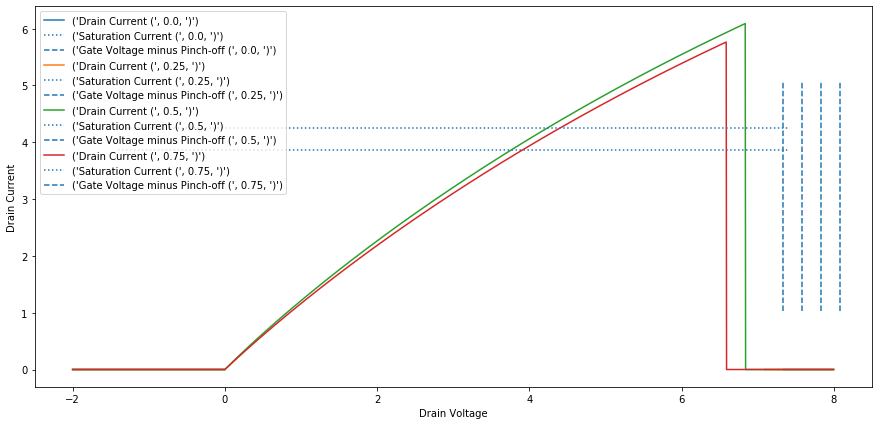

In [0]:
#Produce and display the results on a plot
for i in range(len(vG)):
    plt.plot(vD, iD[i], label=('Drain Current (', vG[i],')'))
    plt.axhline(y=iDSat[i], xmin = 0.1, xmax = 0.9, label=('Saturation Current (', vG[i],')'), linestyle=':')
    plt.axvline(x=(vG[i] - vBI + vP), ymin=0.2, ymax=0.8, label=('Gate Voltage minus Pinch-off (', vG[i],')'), linestyle='--')
plt.legend()
plt.xlabel('Drain Voltage')
plt.ylabel('Drain Current')
plt.savefig('Drain_Current', format='png', dpi=400)
plt.show()